In [149]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
%matplotlib inline

In [150]:
img = cv2.imread('./test_images/Isa1.jpg')
img.shape

(1920, 886, 3)

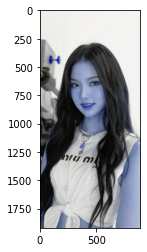

In [151]:
plt.imshow(img)

In [152]:
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
gray.shape

(1920, 886)

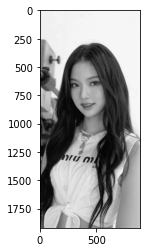

In [153]:
plt.imshow(gray, cmap='gray')

In [154]:
face_cascade = cv2.CascadeClassifier('./opencv/haarcascades/haarcascade_frontalface_default.xml')
eye_cascade = cv2.CascadeClassifier('./opencv/haarcascades/haarcascade_eye.xml')

faces = face_cascade.detectMultiScale(gray, 1.3, 5)
faces

array([[206, 534, 374, 374]])

In [155]:
(x,y,w,h) = faces[0]
x,y,w,h

(206, 534, 374, 374)

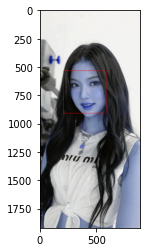

In [156]:
face_img = cv2.rectangle(img,(x,y),(x+w,y+h),(255,0,0),2)
plt.imshow(face_img)

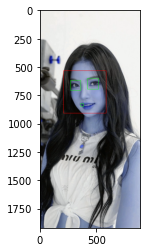

In [157]:
cv2.destroyAllWindows()
for (x,y,w,h) in faces:
    face_img = cv2.rectangle(img,(x,y),(x+w,y+h),(255,0,0),2)
    roi_gray = gray[y:y+h, x:x+w]
    roi_color = face_img[y:y+h, x:x+w]
    eyes = eye_cascade.detectMultiScale(roi_gray)
    for (ex,ey,ew,eh) in eyes:
        cv2.rectangle(roi_color,(ex,ey),(ex+ew,ey+eh),(0,255,0),2)
        

plt.figure()
plt.imshow(face_img, cmap='gray')
plt.show()

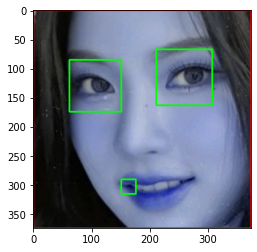

In [158]:
%matplotlib inline
plt.imshow(roi_color, cmap='gray')

In [159]:
cropped_img = np.array(roi_color)
cropped_img.shape

(374, 374, 3)

In [160]:
def get_cropped_image_if_2_eyes(image_path):
    img = cv2.imread(image_path)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray, 1.3, 5)
    for (x,y,w,h) in faces:
        roi_gray = gray[y:y+h, x:x+w]
        roi_color = img[y:y+h, x:x+w]
        eyes = eye_cascade.detectMultiScale(roi_gray)
        if len(eyes) >= 2:
            return roi_color

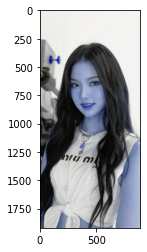

In [161]:
original_image = cv2.imread('./test_images/Isa1.jpg')
plt.imshow(original_image)

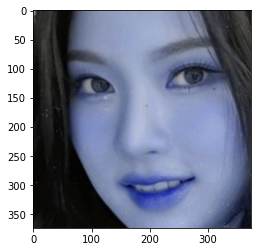

In [162]:
cropped_image = get_cropped_image_if_2_eyes('./test_images/Isa1.jpg')
plt.imshow(cropped_image)

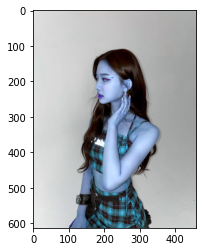

In [163]:
org_image_obstructed = cv2.imread('./test_images/Isa2.jpg')
plt.imshow(org_image_obstructed)

In [164]:
cropped_image_no_2_eyes = get_cropped_image_if_2_eyes('./test_images/Isa2.jpg')
cropped_image_no_2_eyes

In [165]:
path_to_data = "./dataset/"
path_to_cr_data = "./dataset/cropped/"

In [166]:
import os
img_dirs = []
for entry in os.scandir(path_to_data):
    if entry.is_dir():
        img_dirs.append(entry.path)

In [167]:
img_dirs

['./dataset/cropped',
 './dataset/Isa',
 './dataset/J',
 './dataset/Se-eun',
 './dataset/Si-eun',
 './dataset/Sumin',
 './dataset/Yoon']

In [168]:
import shutil
if os.path.exists(path_to_cr_data):
     shutil.rmtree(path_to_cr_data)
os.mkdir(path_to_cr_data)

In [ ]:
cropped_image_dirs = []
celebrity_file_names_dict = {}
for img_dir in img_dirs:
    count = 1
    celebrity_name = img_dir.split('/')[-1]
    celebrity_file_names_dict[celebrity_name] = []
    for entry in os.scandir(img_dir):
        roi_color = get_cropped_image_if_2_eyes(entry.path)
        if roi_color is not None:
            cropped_folder = path_to_cr_data + celebrity_name
            if not os.path.exists(cropped_folder):
                os.makedirs(cropped_folder)
                cropped_image_dirs.append(cropped_folder)
                print("Generating cropped images in folder: ",cropped_folder)
            cropped_file_name = celebrity_name + str(count) + ".png"
            cropped_file_path = cropped_folder + "/" + cropped_file_name
            cv2.imwrite(cropped_file_path, roi_color)
            celebrity_file_names_dict[celebrity_name].append(cropped_file_path)
            count += 1

In [ ]:
import numpy as np
import pywt
import cv2    

def w2d(img, mode='haar', level=1):
    imArray = img
    #Datatype conversions
    #convert to grayscale
    imArray = cv2.cvtColor( imArray,cv2.COLOR_RGB2GRAY )
    #convert to float
    imArray =  np.float32(imArray)   
    imArray /= 255;
    # compute coefficients 
    coeffs=pywt.wavedec2(imArray, mode, level=level)

    #Process Coefficients
    coeffs_H=list(coeffs)  
    coeffs_H[0] *= 0;  

    # reconstruction
    imArray_H=pywt.waverec2(coeffs_H, mode);
    imArray_H *= 255;
    imArray_H =  np.uint8(imArray_H)

    return imArray_H

In [ ]:
im_har = w2d(cropped_img,'db1',5)
plt.imshow(im_har, cmap='gray')

In [ ]:
celebrity_file_names_dict = {}
for img_dir in cropped_image_dirs:
    celebrity_name = img_dir.split('/')[-1]
    file_list = []
    for entry in os.scandir(img_dir):
        file_list.append(entry.path)
    celebrity_file_names_dict[celebrity_name] = file_list
celebrity_file_names_dict

In [170]:
class_dict = {}
count = 0
for celebrity_name in celebrity_file_names_dict.keys():
    class_dict[celebrity_name] = count
    count = count + 1
class_dict

{'cropped': 0, 'Isa': 1}

In [171]:
X, y = [], []
for celebrity_name, training_files in celebrity_file_names_dict.items():
    for training_image in training_files:
        img = cv2.imread(training_image)
        if img is None:
            continue
        scalled_raw_img = cv2.resize(img, (32, 32))
        img_har = w2d(img,'db1',5)
        scalled_img_har = cv2.resize(img_har, (32, 32))
        combined_img = np.vstack((scalled_raw_img.reshape(32*32*3,1),scalled_img_har.reshape(32*32,1)))
        X.append(combined_img)
        y.append(class_dict[celebrity_name])

In [172]:
len(X)

4

In [173]:
X = np.array(X).reshape(len(X),4096).astype(float)
X.shape

(4, 4096)

In [174]:
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report

In [117]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

pipe = Pipeline([('scaler', StandardScaler()), ('svc', SVC(kernel = 'rbf', C = 10))])
pipe.fit(X_train, y_train)
pipe.score(X_test, y_test)

0.5409836065573771

In [57]:
print(classification_report(y_test, pipe.predict(X_test)))

              precision    recall  f1-score   support

           0       0.39      0.64      0.48        11
           1       0.73      0.73      0.73        15
           2       0.50      0.31      0.38        13
           3       0.58      0.47      0.52        15
           4       0.50      0.57      0.53         7

    accuracy                           0.54        61
   macro avg       0.54      0.54      0.53        61
weighted avg       0.56      0.54      0.54        61



In [58]:
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV

In [105]:
model_params = {
    'svm': {
        'model': svm.SVC(gamma='auto',probability=True),
        'params' : {
            'svc__C': [1,10,100,1000],
            'svc__kernel': ['rbf','linear']
        }  
    },
    'random_forest': {
        'model': RandomForestClassifier(),
        'params' : {
            'randomforestclassifier__n_estimators': [1,5,10]
        }
    },
    'logistic_regression' : {
        'model': LogisticRegression(solver='liblinear',multi_class='auto'),
        'params': {
            'logisticregression__C': [1,5,10]
        }
    }
}

In [ ]:
scores = []
best_estimators = {}
import pandas as pd
for algo, mp in model_params.items():
    pipe = make_pipeline(StandardScaler(), mp['model'])
    clf =  GridSearchCV(pipe, mp['params'], cv=5, return_train_score=False)
    clf.fit(X_train, y_train)
    scores.append({
        'model': algo,
        'best_score': clf.best_score_,
        'best_params': clf.best_params_
    })
    best_estimators[algo] = clf.best_estimator_
    
df = pd.DataFrame(scores,columns=['model','best_score','best_params'])

In [ ]:
df

In [ ]:
best_estimators

In [ ]:
best_estimators['svm'].score(X_test,y_test)

In [ ]:
best_estimators['random_forest'].score(X_test,y_test)

In [ ]:
best_estimators['logistic_regression'].score(X_test,y_test)

In [ ]:
best_clf = best_estimators['svm']

In [ ]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, best_clf.predict(X_test))
cm

Text(69.0, 0.5, 'Truth')

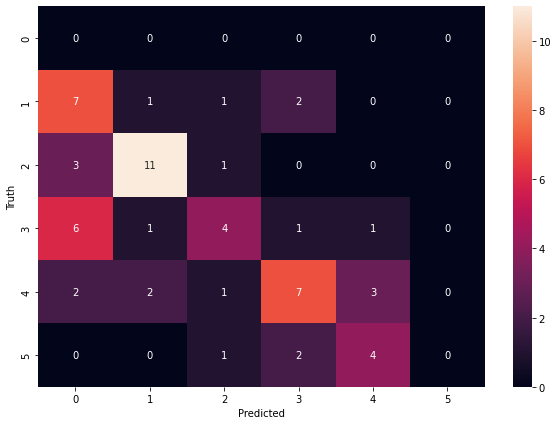

In [146]:
import seaborn as sn
plt.figure(figsize = (10,7))
sn.heatmap(cm, annot=True)
plt.xlabel('Predicted')
plt.ylabel('Truth')

In [ ]:
class_dict

In [ ]:
!pip install joblib
import joblib 
joblib.dump(best_clf, 'saved_model.pkl')

In [ ]:
import json
with open("class_dictionary.json","w") as f:
    f.write(json.dumps(class_dict))

In [ ]:
class_dict= {"Isa": 0, "J": 1, "Se-eun": 2, "Si-eun": 3, "Sumin": 4, "Yoon": 5}

In [147]:
class_dict

{'Isa': 0, 'J': 1, 'Se-eun': 2, 'Si-eun': 3, 'Sumin': 4, 'Yoon': 5}